Our code base is built off of https://github.com/fpingham/DeepSteg/blob/master/DeepSteganography.ipynb

Their implementation however, misinterpreted the original paper, and couldn't get any actual decoding results. The core of the issue was that they had several networks of differing kernel size for every model, when in reality the paper describes a concept similar to the inception module, where a number of different patch sizes are used, and their outputs are all concatenated for the next layer to use.

We modify the paper architecture very slightly too by using 1,3,5 as the patch sizes. The lack of depthwise convolutions seemed strange to me, especially since very specific local textures would need to be handled through them and couldn't be appropriately described with larger patch sizes.

Ours is a much smaller variation of the original too, as for the purposes of experiment, we needed to be able to iterate rapidly.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
from model import *
import torch
import torch.nn as nn
import numpy as np

In [3]:
net = Net()
net.load_state_dict(torch.load('models/Epoch N10.pkl'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.13 
Loss on secret: 0.09 
Loss on cover: 0.05


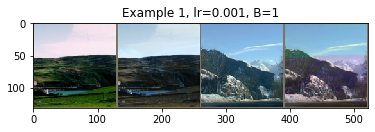

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.05 
Loss on secret: 0.03 
Loss on cover: 0.02


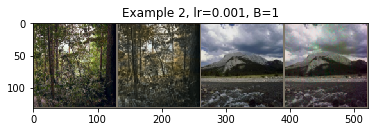

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.07 
Loss on secret: 0.05 
Loss on cover: 0.02


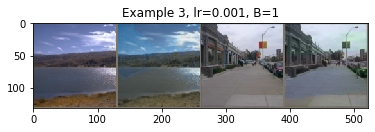

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.43 
Loss on secret: 0.32 
Loss on cover: 0.11


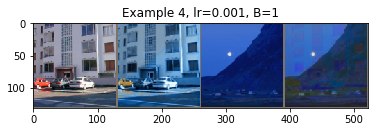

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 0.32 
Loss on secret: 0.16 
Loss on cover: 0.16


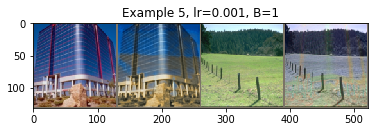

In [4]:
net.eval()

test_losses = []
#We don't expect any meaningful test losses here.
#We mostly want to take a qualitative look at the results.
for idx, test_batch in enumerate(test_loader):
     # Saves images
    data, _ = test_batch

    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    test_secret = Variable(test_secret, volatile=True)
    test_cover = Variable(test_cover, volatile=True)

    # Compute output
    test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
#     diff_S, diff_C = np.abs(np.array(test_output.data[0]) - np.array(test_secret.data[0])), np.abs(np.array(test_hidden.data[0]) - np.array(test_cover.data[0]))
    
#     print (diff_S, diff_C)
    
    if idx in [0,1,2,3,4]:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(test_loss.data.item(), loss_secret.data.item(), loss_cover.data.item()))

        # Creates img tensor
        imgs = [test_secret.data, test_output.data, test_cover.data, test_hidden.data]
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)
    else:
        break
    test_losses.append(test_loss.data.item())       